In [1]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 40000

# Number of epochs
epoch_t = 15

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set 
test_size = 0.3

# number of folds
n_folds = 10

_____________________________________________________________________

In [2]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [4]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [6]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/misc"
    for files in os.listdir(dir):
        if "cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/misc/cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

No matches found
New folder name: cnn-local-v001
--------------


**Data**


In [7]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"

Load the data. No data augmentation takes place

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [15]:
labels_flat = np.argmax(labels, axis=1)

In [72]:
rw_count = 0
bn_count = 0
for i in labels_flat:
    if i <= 9:
        rw_count += 1
    else:
        bn_count += 1

In [74]:
bin_perc = np.array([rw_count, bn_count]) / (rw_count + bn_count) * 100

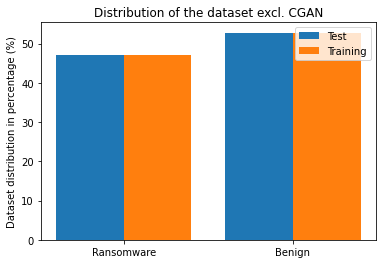

In [78]:
plt.bar(np.arange(2) - 0.2, bin_perc, 0.4, label = 'Test')
plt.bar(np.arange(2) + 0.2, bin_perc, 0.4, label = 'Training')

plt.title('Distribution of the dataset excl. CGAN')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(range(2), ['Ransomware', 'Benign'], rotation='horizontal')
plt.legend()

if cenv == 0:
    plt.savefig("bin_data_dist_test_train.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist_test_train.png", bbox_inches = 'tight', dpi = 150)

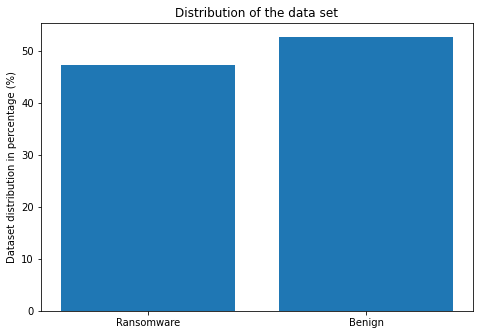

In [87]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [rw_count / (bn_count + rw_count) * 100, bn_count / (bn_count + rw_count) * 100]
plt.title('Distribution of the data set')
plt.ylabel('Dataset distribution in percentage (%)')
ax.bar(x_lab, y_lab)
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [82]:
multi_labels = list(batches.class_indices.keys())

In [83]:
multi_perc = np.array(np.unique(labels_flat, return_counts=True)[1]) / labels_flat.shape[0] * 100

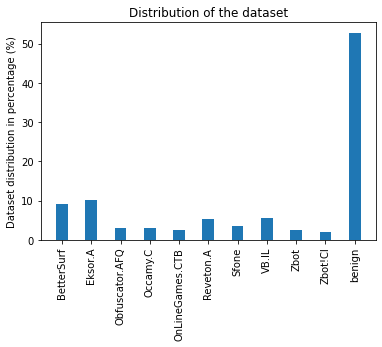

In [84]:
plt.bar(range(11), multi_perc, 0.4, label = 'Training')

plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(range(11), multi_labels, rotation='vertical')

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

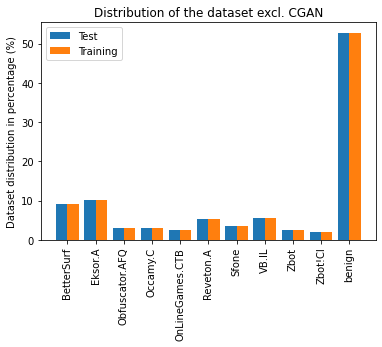

In [85]:
plt.bar(np.arange(11) - 0.2, multi_perc, 0.4, label = 'Test')
plt.bar(np.arange(11) + 0.2, multi_perc, 0.4, label = 'Training')

plt.title('Distribution of the dataset excl. CGAN')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(range(11), multi_labels, rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist_test_train.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist_test_train.png", bbox_inches = 'tight', dpi = 150)